In [22]:
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
DIR = './processed/'

In [6]:
sie_pi = pd.read_csv(DIR+'CMIP6-21_SIE_piControl.csv',index_col=0,parse_dates=True)
models=sie_pi.columns.to_list()
models

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CanESM5',
 'EC-Earth3',
 'EC-Earth3-CC',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'FIO-ESM-2-0',
 'GFDL-ESM4',
 'IPSL-CM5A2-INCA',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorCPM1',
 'NorESM2-MM',
 'SAM0-UNICON',
 'TaiESM1']

In [ ]:
cmip6 = google_cmip_col()

In [ ]:
#extract from the catalogue SIC and cell area
cat = cmip6.search(
    source_id=models,
    variable_id='siconc', 
    table_id='SImon',
    experiment_id='piControl',
    member_id='r1i1p1f1',
    grid_label='gn'
)
ddict = cat.to_dataset_dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True},
)

In [9]:
ddict.keys()

dict_keys(['CMIP.IPSL.IPSL-CM5A2-INCA.piControl.SImon.gn', 'CMIP.MIROC.MIROC6.piControl.SImon.gn', 'CMIP.CMCC.CMCC-ESM2.piControl.SImon.gn', 'CMIP.NOAA-GFDL.GFDL-ESM4.piControl.SImon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3.piControl.SImon.gn', 'CMIP.NCC.NorCPM1.piControl.SImon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.piControl.SImon.gn', 'CMIP.AS-RCEC.TaiESM1.piControl.SImon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-CC.piControl.SImon.gn', 'CMIP.SNU.SAM0-UNICON.piControl.SImon.gn', 'CMIP.CSIRO.ACCESS-ESM1-5.piControl.SImon.gn', 'CMIP.MPI-M.MPI-ESM1-2-HR.piControl.SImon.gn', 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.SImon.gn', 'CMIP.FIO-QLNM.FIO-ESM-2-0.piControl.SImon.gn', 'CMIP.MPI-M.MPI-ESM1-2-LR.piControl.SImon.gn', 'CMIP.CMCC.CMCC-CM2-SR5.piControl.SImon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.piControl.SImon.gn', 'CMIP.NCC.NorESM2-MM.piControl.SImon.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.piControl.SImon.gn', 'CMIP.MRI.MRI-ESM2-0.piControl.SImon.gn', 'CMIP.CCCma.CanESM5.piControl.S

In [20]:
def findedge(sic):
    # this function is quite a hack and not optimized to work with cloud data, sorry!
    import numpy as np
    from scipy.interpolate import interp1d
    from calendar import month_abbr
    import pandas as pd
  
    N,JM,IM = sic.shape
    lat = sic.lat.values
    lon = sic.lon.values
    edgelat=np.ones([IM])
    edgelon=np.ones([IM])
    # interpolating grid
    ilon = np.arange(0,360,0.5)
    ilat = np.ones([N,len(ilon)])

    for t in range(N): # iterate over time
        if (t % 10 == 0):
            print('month: ',t)
        c = sic.isel(time=t).values
        for i in range(IM):           #iterating over every longitude
            ice=np.where(c[:,i]>0)[0] #find indices where SIC>0
            if ice.size == 0:         #if no ice, make both coords NaN
                edgelat[i]=np.NaN
                edgelon[i]=np.NaN
            else:
                jice=ice[-1]           #otherwise, take the last index and store coords
                edgelat[i]=lat[jice,i]
                edgelon[i]=lon[jice,i]
        f = interp1d(edgelon, edgelat, bounds_error=False, fill_value='extrapolate')
        ilat[t,:] = f(ilon)

    # calculate climatologies and create the dataframe
    months = [month_abbr[i] for i in [1,2,11,12]]
    months_std = [month_abbr[i]+'_std' for i in [1,2,11,12]]
    df = pd.DataFrame(index=ilon,columns=months+months_std)
    df.index.name = 'Longitude'
    jan = ilat[range(0,N,4),:] # extract the rows corresponding to the month (4 month * 100 years)
    feb = ilat[range(1,N,4),:]
    nov = ilat[range(2,N,4),:]
    dec = ilat[range(3,N+1,4),:]
    df['Jan'] = np.median(jan,axis=0)
    df['Jan_std'] = np.std(jan,axis=0)
    df['Feb'] = np.median(feb,axis=0)
    df['Feb_std'] = np.std(feb,axis=0)
    df['Nov'] = np.median(nov,axis=0)
    df['Nov_std'] = np.std(nov,axis=0)
    df['Dec'] = np.median(dec,axis=0)
    df['Dec_std'] = np.std(dec,axis=0)
    return df

In [ ]:
# find edge and store the dataframe
for name, ds in ddict.items():
    print(name)
    mname = ds.attrs['source_id']
    # extract the last 100 years (1200 months)
    NT = ds.time.shape[0]
    ds = ds.isel(time=slice(NT-1200,NT))
    sic = ds.siconc.squeeze()
    sic = sic.sel(time=sic.time.dt.month.isin([11,12,1,2])) # extract summer months
    mask = (sic.lat < -40.).compute() # need to carry out the computation because of dask chunks
    sic_sh = sic.where(mask, drop=True)
    df = findedge(sic_sh)
    df.to_csv(mname+'_edge_piControl.csv')


In [23]:
# group all the models to calculate statistics for the 4 months
# the longitude index is set to the range -180,180
# model data will be sorted
ilon = np.arange(0,360,0.5)
lon180 = np.where(ilon>180,ilon-360,ilon)
dfj = pd.DataFrame(index=lon180,columns=models)
dfj.index.name = 'Longitude'
dff = dfj.copy()
dfn = dfj.copy()
dfd = dfj.copy()

for m in models:
    df = pd.read_csv(m+'_edge_piControl.csv',index_col=0)
    dfj[m] = df['Jan'].values
    dff[m] = df['Feb'].values
    dfn[m] = df['Nov'].values
    dfd[m] = df['Dec'].values

# sort by longitude
dfj.sort_index(inplace=True)
dff.sort_index(inplace=True)
dfn.sort_index(inplace=True)
dfd.sort_index(inplace=True)

In [24]:
dfj.to_csv('CMIP6-21_SIedge_Jan_piControl.csv')
dff.to_csv('CMIP6-21_SIedge_Feb_piControl.csv')
dfn.to_csv('CMIP6-21_SIedge_Nov_piControl.csv')
dfd.to_csv('CMIP6-21_SIedge_Dec_piControl.csv')

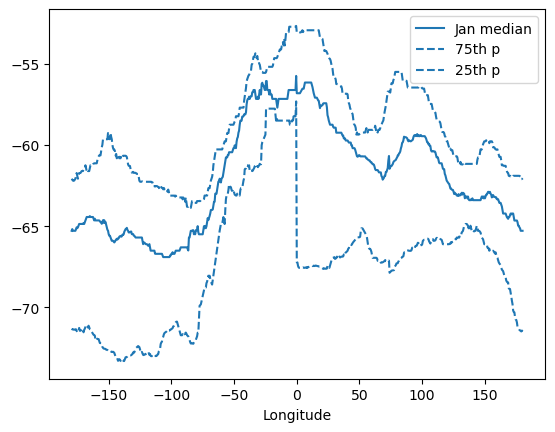

In [25]:
# plot test figure
Mjan = dfj.median(axis=1)
p75jan = dfj.quantile(0.75,axis=1)
p25jan = dfj.quantile(0.25,axis=1)
plt.figure()
Mjan.plot(label='Jan median')
p75jan.plot(color='C0',linestyle='--',label='75th p')
p25jan.plot(color='C0',linestyle='--',label='25th p')
plt.legend()

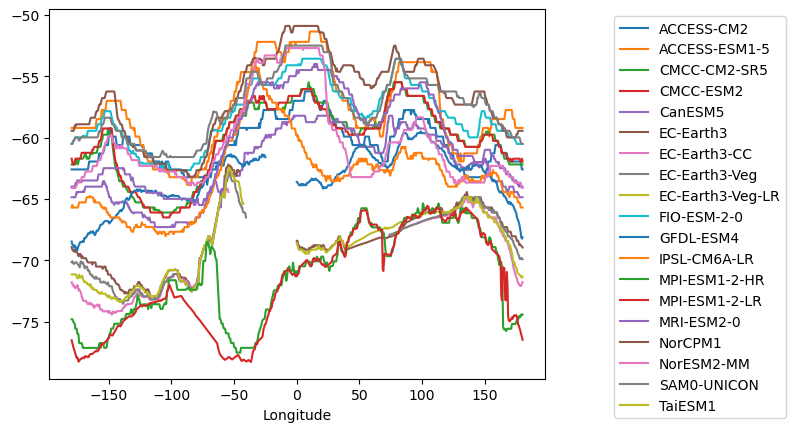

In [32]:
# some models are empty (retained) and some others have weird latitudes. 
tmp = dfj.drop(columns=['MIROC6','IPSL-CM5A2-INCA'])
tmp.plot()
plt.legend(loc='upper right', bbox_to_anchor=(1.5,1))